<a href="https://colab.research.google.com/github/syedabusafwan/syedabusafwan/blob/practice/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Preparation**

In [1]:
from ast import increment_lineno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')


In [2]:
!pip install -q kaggle


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list





cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [4]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 49.4MB/s]
100% 15.1M/15.1M [00:00<00:00, 93.4MB/s]


In [5]:
!mkdir train


In [6]:
!unzip '/content/brain-mri-images-for-brain-tumor-detection.zip' -d '/content/train'

Archive:  /content/brain-mri-images-for-brain-tumor-detection.zip
  inflating: /content/train/brain_tumor_dataset/no/1 no.jpeg  
  inflating: /content/train/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/14 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/15 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/17 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/18 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/19 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/2 no.jpeg  
  inflating: /content/train/brain_tumor_dataset/no/20 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/21 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/22 no.jpg  
  inflating: /content/train/brain_tumor_dataset/no/2

In [7]:
#deta preparation
folder = '/content/train/brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "Y_" + str(count) + ".jpg"
  os.rename(source, destination)
  count += 1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [8]:
folder = '/content/train/brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "N_" + str(count) + ".jpg"
  os.rename(source, destination)
  count += 1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


**EDA**

In [9]:
listyes = os.listdir('/content/train/brain_tumor_dataset/yes/')
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir('/content/train/brain_tumor_dataset/no/')
number_files_no = len(listno)
print(number_files_no)

155
98


In [10]:
#PLOT

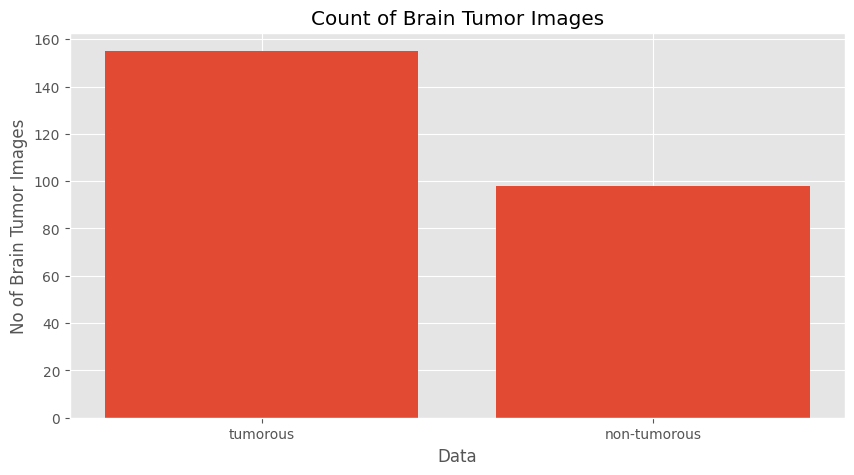

In [11]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize = (10,5))
plt.bar(typex, values)

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

**Data Augmentation**

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [22]:
def timing(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60) / 60))
  s = sec_elapsed % 60

  return f"{h}:{m}:{s}"

In [17]:
def augmented_data(file_dir, n_genarated_samples, save_to_dir):
  data_gen = ImageDataGenerator(rotation_range=15,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                brightness_range=(0.3, 1.0),
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
  for filename in os.listdir(file_dir):
    image = cv2.imread(file_dir + '/' + filename)
    image = image.reshape((1,) + image.shape)
    save_prefix = 'aug_' + filename[:-4]
    i=0
    for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = 'jpg'):
      i += 1
      if i>n_genarated_samples:
        break


In [20]:
def augmented_data(file_dir, n_genarated_samples, save_to_dir):
  data_gen = ImageDataGenerator(rotation_range=15,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                brightness_range=(0.3, 1.0),
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
  for filename in os.listdir(file_dir):
    image = cv2.imread(file_dir + '/' + filename)
    # Call the reshape method with the correct dimensions. Assuming you want to add a dimension at the beginning:
    image = image.reshape((1,) + image.shape)
    save_prefix = 'aug_' + filename[:-4]
    i=0
    for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = 'jpg'):
      i += 1
      if i>n_genarated_samples:
        break

In [23]:
import time
start_time = time.time()

yes_path = '/content/train/brain_tumor_dataset/yes'
no_path = '/content/train/brain_tumor_dataset/no'

augmented_data_path = '/content/train/augmented_data/'

augmented_data(file_dir = yes_path, n_genarated_samples=6, save_to_dir=augmented_data_path + 'yes')
augmented_data(file_dir = no_path, n_genarated_samples=9, save_to_dir=augmented_data_path + 'no')

end_time = time.time()
execution_time = end_time + start_time
print(timing(execution_time))

959578:5:26.16070795059204


In [26]:
def data_summary(main_path):
  yes_path = '/content/train/augmented_data/yes'
  no_path = '/content/train/augmented_data/no'

  n_pos = len(os.listdir(yes_path))
  n_neg = len(os.listdir(no_path))

  n = n_pos + n_neg

  pos_per = (n_pos*100)/n
  neg_per = (n_neg*100)/n

  print(f"Number of sample{n}")
  print(f"{n_pos} Percentage of Positive:{pos_per}")
  print(f"{n_neg} Percentage of Negative:{neg_per}")

In [27]:
data_summary(augmented_data_path)

Number of sample4125
2169 Percentage of Positive:52.58181818181818
1956 Percentage of Negative:47.41818181818182


**Data Preprocessing**

**Data Spilitting**

**Model Building**

**Unfreezing and fine tuning**